In [1]:
import os.path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_context("talk")
sns.set_style("white")

In [2]:
from jsuresh_helpers.analyzers.create_sim_map import get_sim_map
from jsuresh_helpers.burnins.run_ssmt_sharon_hack import run_burnin_endpoint_ssmt
from jsuresh_helpers.binning_and_smoothing import fit_lowess_spline
from jsuresh_helpers.analyzers.run_analyzer import run_analyzer_as_ssmt
from jsuresh_helpers.analyzers.sim_endpoint import SimEndpoint

INI File Used: C:\Users\joshsu\Code\malaria-sac-ipt\idmtools.ini


In [3]:
run_analyzer_as_ssmt(experiment_id="9a81e628-2aa6-ec11-a9f5-9440c9be2c51", analyzers=[SimEndpoint], analyzer_args=[{"save_file": "burnin_map.csv"}])


[SLURM]
{
   "type": "COMPS",
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon",
   "priority": "Highest",
   "simulation_root": "$COMPS_PATH(USER)\\output",
   "num_retries": "0",
   "node_group": "idm_48cores",
   "num_cores": "1",
   "exclusive": "False"
}

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=cb626410-bdab-ec11-a9f6-9440c9be2c51



Waiting on WorkItem SSMT analysis: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.04s/workitem]


SSMTWorkItem(_uid=UUID('cb626410-bdab-ec11-a9f6-9440c9be2c51'), _IItem__pre_creation_hooks=[], _IItem__post_creation_hooks=[], platform_id='f35f9b6d37ad24244e0bd5a0375beb61', _platform=<Platform COMPSPlatform - id: f35f9b6d37ad24244e0bd5a0375beb61>, parent_id=None, _parent=None, status=<EntityStatus.SUCCEEDED: 'succeeded'>, tags={}, item_type=<ItemType.WORKFLOW_ITEM: 'WorkItem'>, _platform_object={
    "id": "cb626410-bdab-ec11-a9f6-9440c9be2c51",
    "name": "SSMT analysis",
    "environment_name": "Calculon",
    "state": "CommissionRequested",
    "tags": {
        "WorkItem_Type": "DockerWorker"
    }
}, _IRunnableEntity__pre_run_hooks=[], _IRunnableEntity__post_run_hooks=[], name='SSMT analysis', assets=AssetCollection(_uid=None, _IItem__pre_creation_hooks=[], _IItem__post_creation_hooks=[], platform_id=None, _platform=None, parent_id=None, _parent=None, status=None, tags={}, item_type=<ItemType.ASSETCOLLECTION: 'Asset Collection'>, _platform_object=None), transient_assets=AssetCo

Waiting on WorkItem Filter outputs for Workitem cb626410-bdab-ec11-a9f6-9440c9be2c51: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.36s/workitem]


In [4]:
df_burnin = pd.read_csv("burnin_map.csv")
df_burnin.drop(columns="task_type", inplace=True)

In [5]:
columns_of_interest = ["aeir",
                       "annual_cases_per_1000",
                       "annual_rdt_prev",
                       "pfemp_frac",
                       "annual_reported_cases_per_1000"]

In [6]:
df_burnin.sort_values(by=["archetype", "habitat_scale", "Run_Number"], inplace=True, ignore_index=True)

df_list = []
for i, sdf in df_burnin.groupby("archetype"):
    for c in columns_of_interest:
        x = sdf["habitat_scale"]
        y = sdf[c]
        xs, ys = fit_lowess_spline(x, y, frac=0.3)

        # Find any negative values and replace them with mean of actual burnin:
        needs_correction = ys < 0
        corrected = np.mean(y[needs_correction])
        ys[needs_correction] = corrected

        sdf[c + "_SMOOTHED"] = ys

    df_list.append(sdf)

df_burnin_with_smoothed = pd.concat(df_list, ignore_index=True)

In [7]:
df_list = []
for i, sdf in df_burnin_with_smoothed.groupby("archetype"):
    archetype = i
    for c in columns_of_interest:
        y = sdf[c]
        ys = sdf[c + "_SMOOTHED"]

        # distance
        d = np.abs(y-ys)**2/ys**2
        sdf[c+ "_DISTANCE"] = d

    for i in range(len(columns_of_interest)):
        if i == 0:
            sdf["TOTAL_DISTANCE"] = sdf[columns_of_interest[i] + "_DISTANCE"]
        else:
            sdf["TOTAL_DISTANCE"] = sdf["TOTAL_DISTANCE"] + sdf[columns_of_interest[i] + "_DISTANCE"]


    # Loop over dataframe (bad?) and find smallest distance burnin for each value of the transmission tag
    dict_list = []
    for i, ssdf in sdf.groupby("habitat_scale"):
        min_dist_row_as_dict = dict(ssdf.loc[ssdf["TOTAL_DISTANCE"].idxmin()])
        dict_list.append(min_dist_row_as_dict.copy())

    min_dist_df = pd.DataFrame(dict_list)

    df_list.append(min_dist_df)

min_dist_full_df = pd.concat(df_list, ignore_index=True)

In [8]:
def plot_burnins(archetype):
    plt.close('all')
    plt.figure(figsize=(8, 8), dpi=200)

    sdf = df_burnin_with_smoothed[df_burnin_with_smoothed["archetype"]==archetype]
    min_dist_this_archetype_df = min_dist_full_df[min_dist_full_df["archetype"]==archetype]
    
    x = sdf["habitat_scale"]
    i = 1
    for c in columns_of_interest:
        y = sdf[c]
        ys = sdf[c + "_SMOOTHED"]

        plt.subplot(3, 2, i)
        plt.scatter(x, y, zorder=0)
        plt.scatter(x, ys, c="C1", zorder=1, marker='.')

        x_selected = min_dist_this_archetype_df["habitat_scale"]
        y_selected = min_dist_this_archetype_df[c]
        plt.scatter(x_selected, y_selected, marker='*', zorder=2, c="C2")

        plt.ylabel(c)
        plt.xlabel("habitat_scale")

        i += 1

    plt.tight_layout()
    plt.show()
    # plt.savefig(f"burnin_endpoints_{archetype}.png")

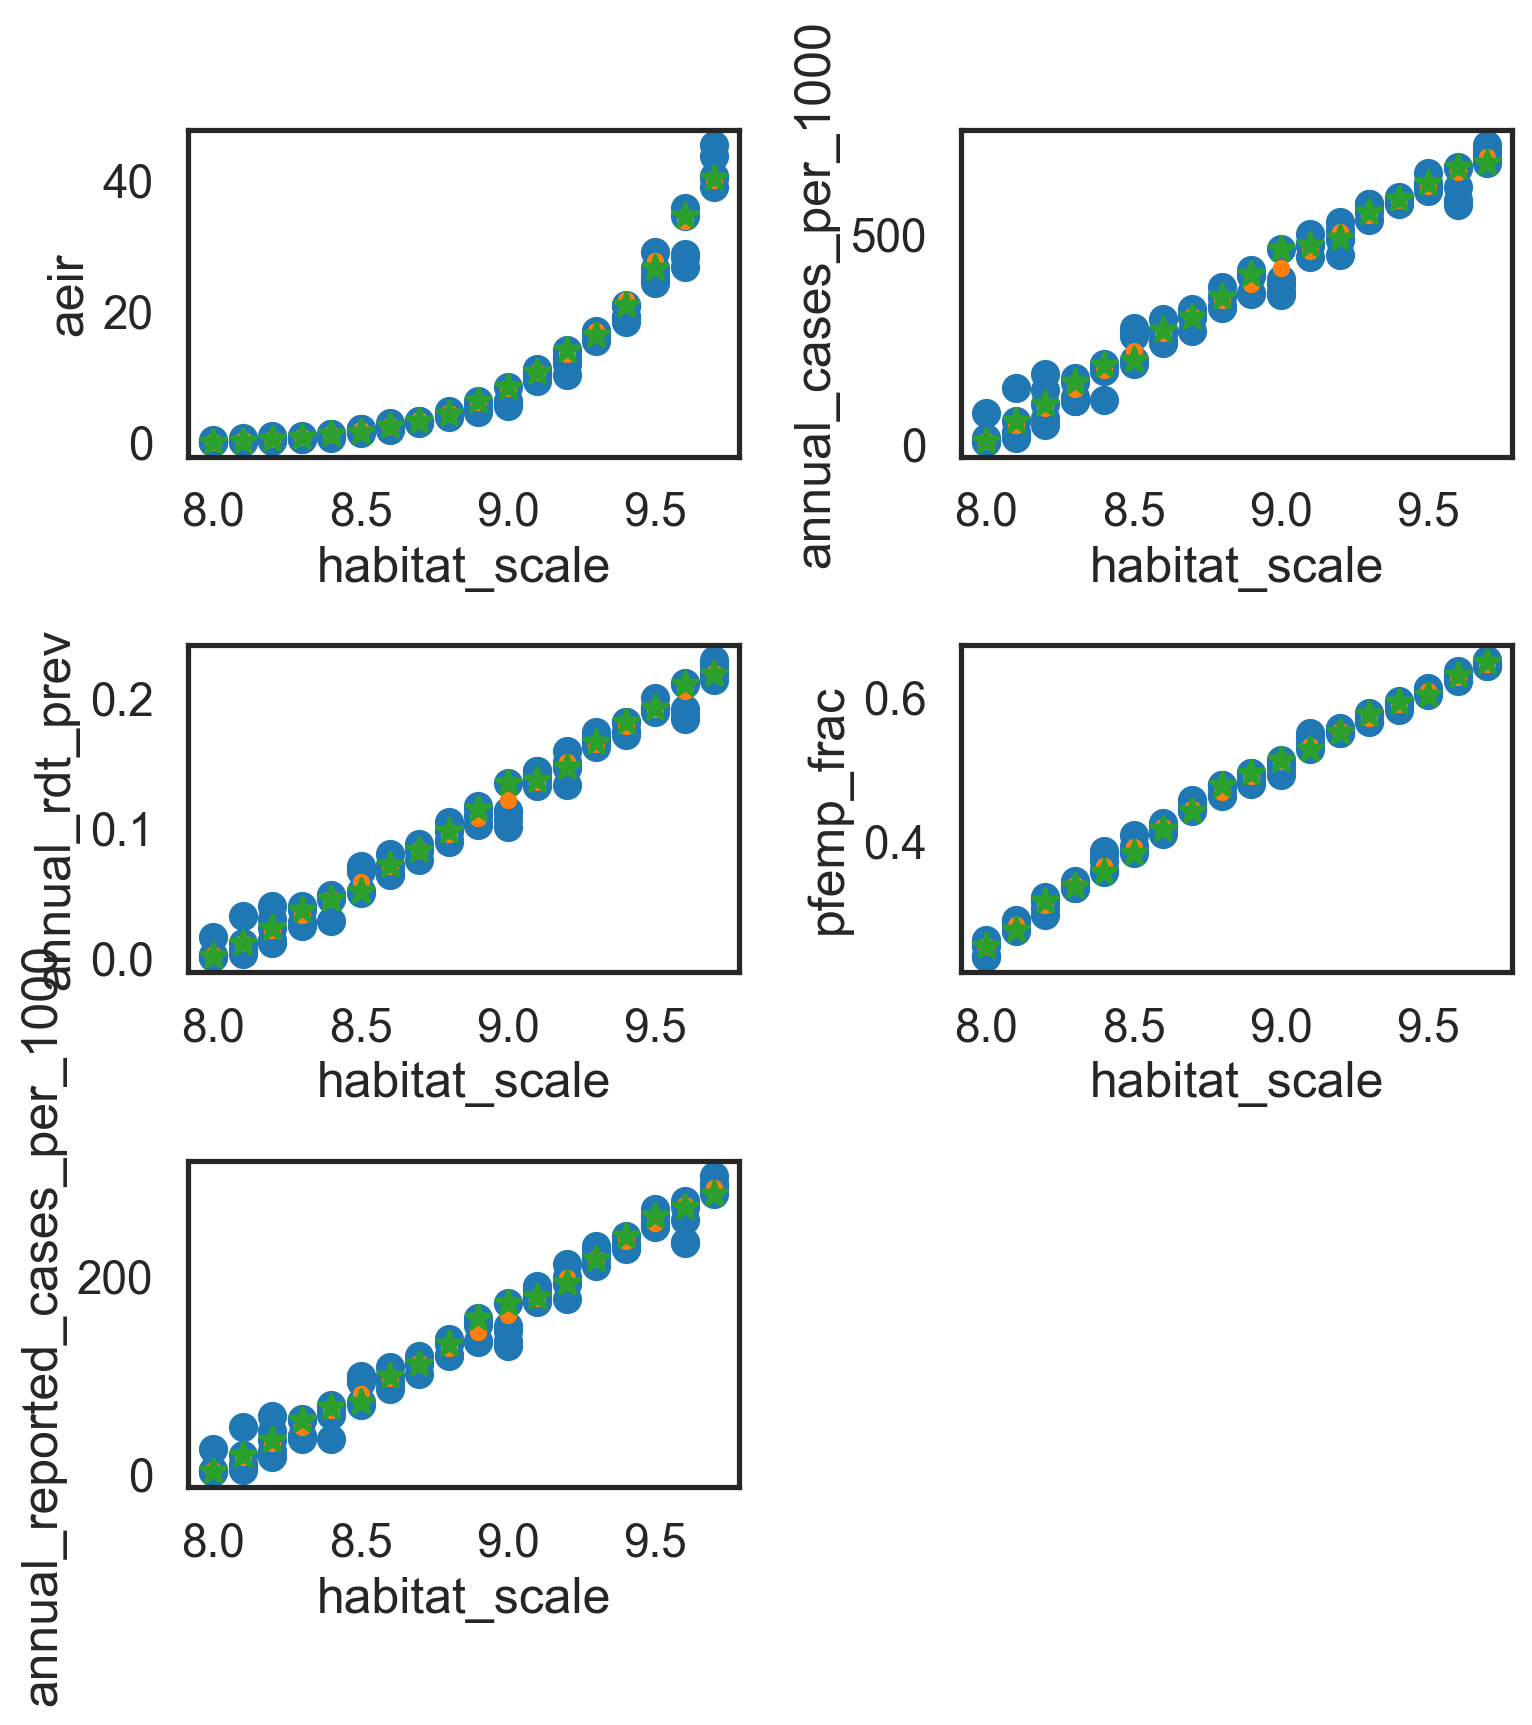

In [9]:
plot_burnins("Sahel")

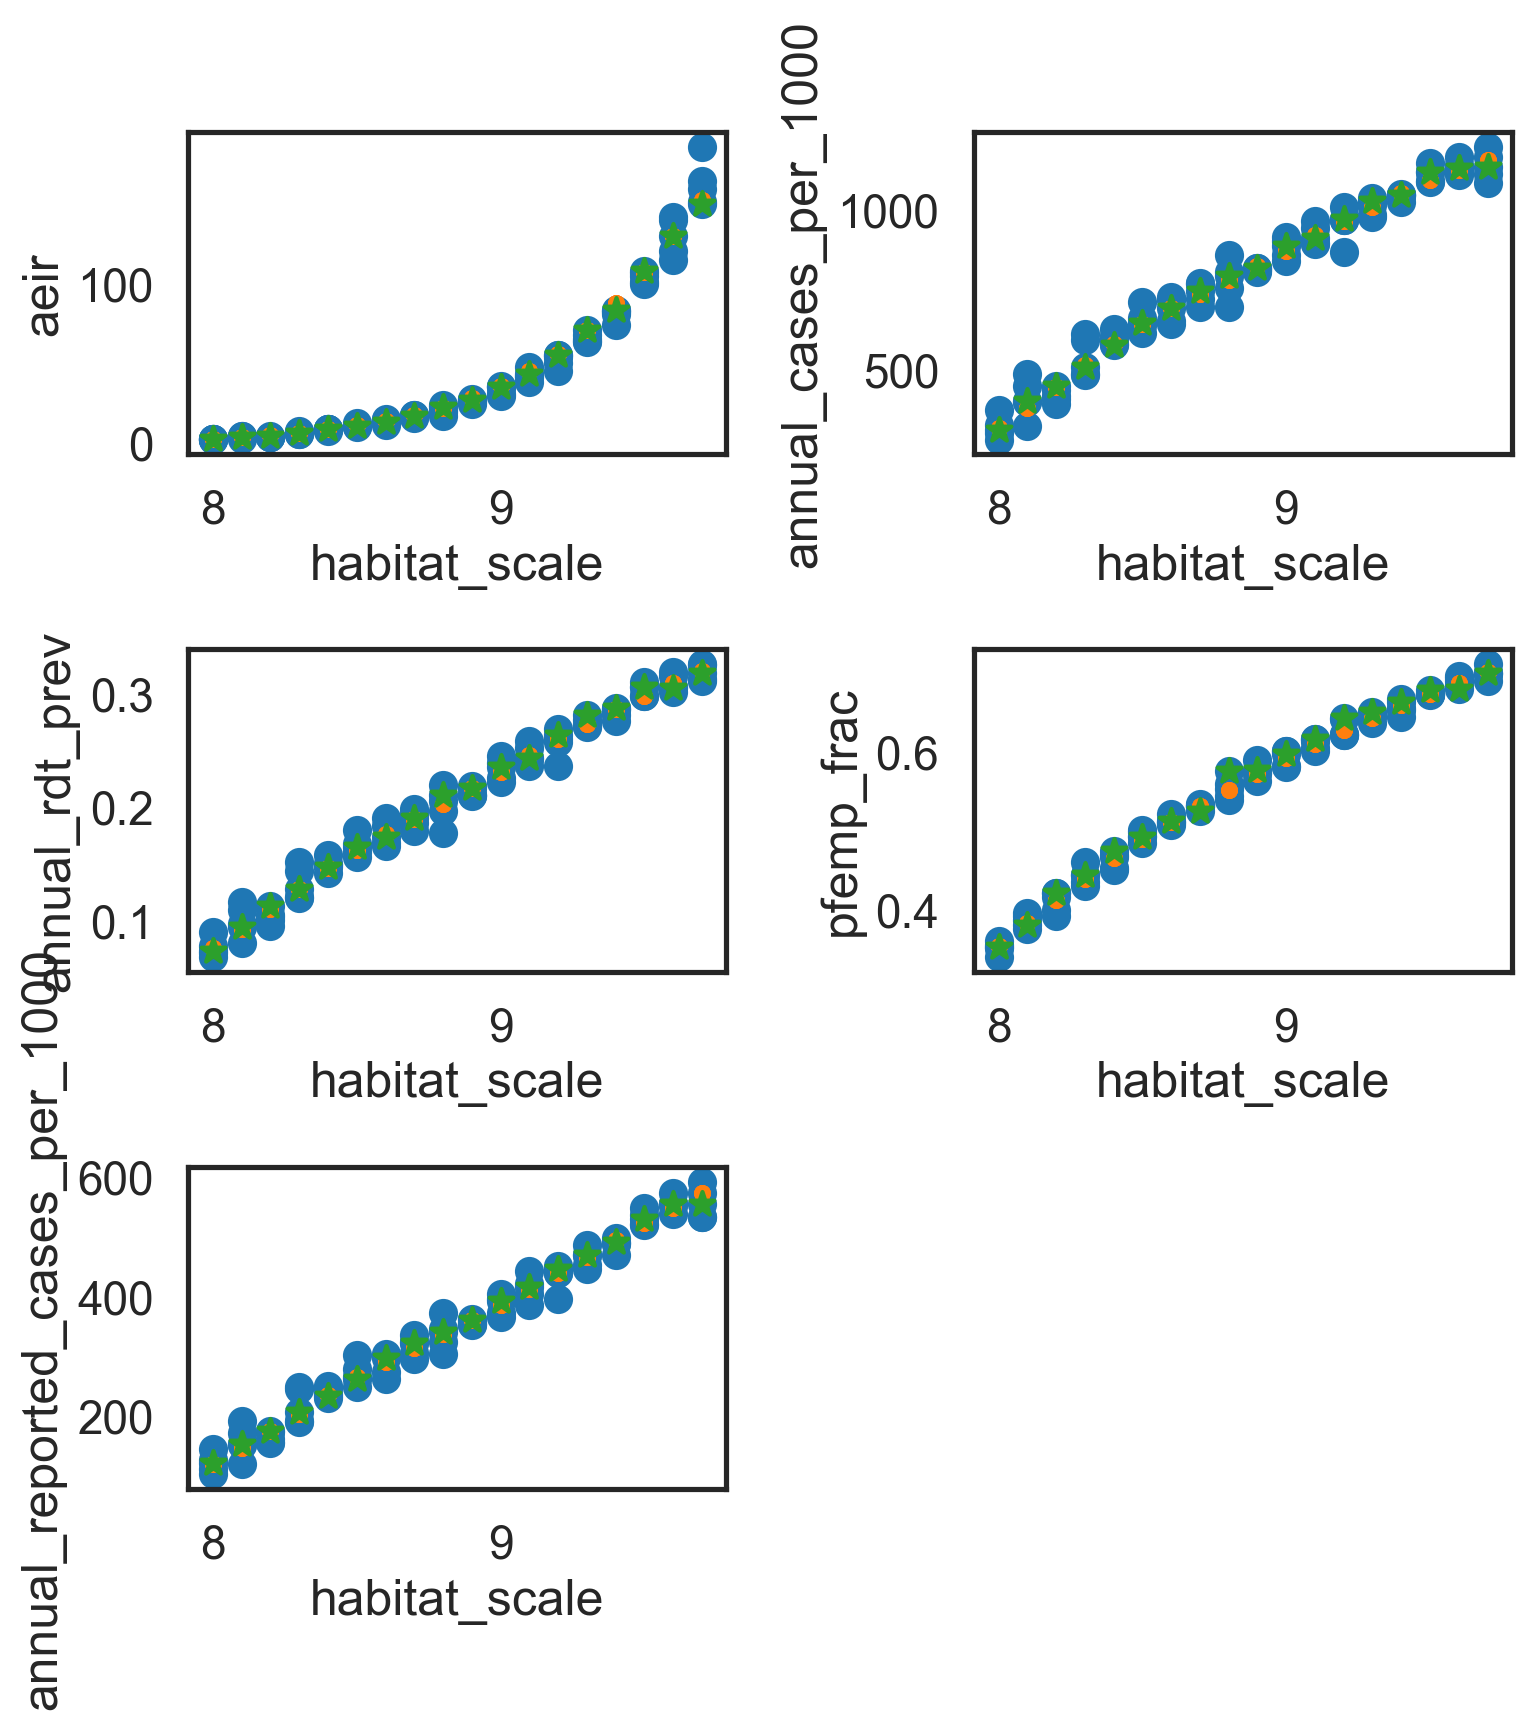

In [10]:
plot_burnins("Southern")

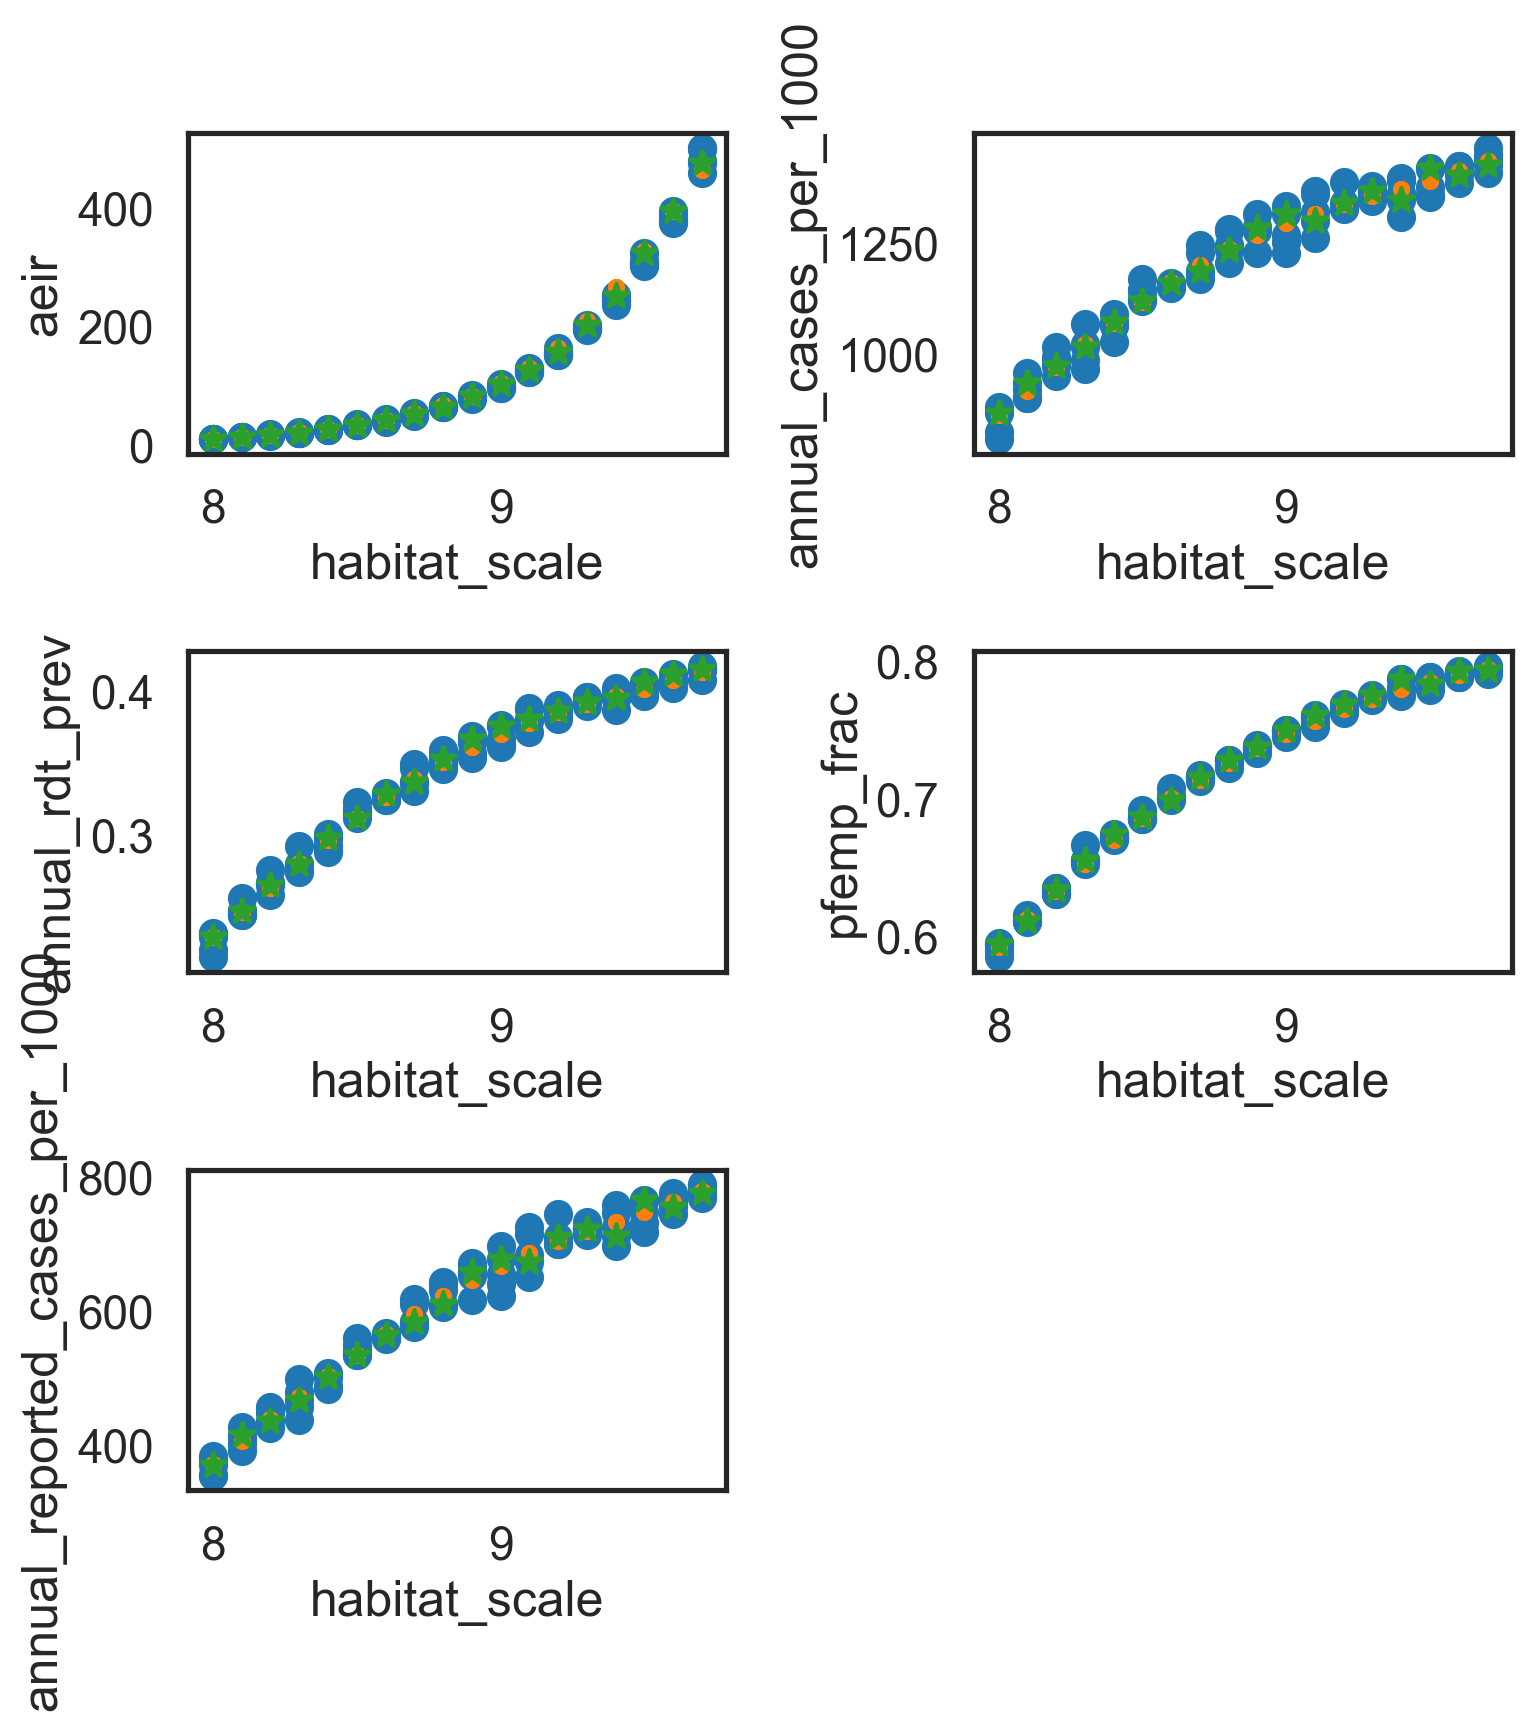

In [11]:
plot_burnins("Central")

In [12]:
for i, sdf in df_burnin_with_smoothed.groupby(["archetype", "habitat_scale"]):
    print(i)
    print(sdf["aeir_SMOOTHED"])

('Central', 8.0)
0    9.661121
1    9.661121
2    9.661121
3    9.661121
4    9.661121
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.1)
5    13.210241
6    13.210241
7    13.210241
8    13.210241
9    13.210241
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.2)
10    16.832385
11    16.832385
12    16.832385
13    16.832385
14    16.832385
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.3)
15    21.269882
16    21.269882
17    21.269882
18    21.269882
19    21.269882
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.4)
20    26.874767
21    26.874767
22    26.874767
23    26.874767
24    26.874767
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.5)
25    33.807173
26    33.807173
27    33.807173
28    33.807173
29    33.807173
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.6)
30    42.499394
31    42.499394
32    42.499394
33    42.499394
34    42.499394
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.7)
35    53.29488
36    53.29488
37    53.29488
38    53.29488
39    5

In [13]:
df_burnin_with_smoothed

,aeir,annual_cases_per_1000,annual_rdt_prev,pfemp_frac,annual_reported_cases_per_1000,sim_id,archetype,habitat_scale,Run_Number,aeir_SMOOTHED,annual_cases_per_1000_SMOOTHED,annual_rdt_prev_SMOOTHED,pfemp_frac_SMOOTHED,annual_reported_cases_per_1000_SMOOTHED
0,10.488276,873.367831,0.232073,0.589252,384.249453,e2b9dc3d-2aa6-ec11-a9f5-9440c9be2c51,Central,8.0,0,9.661121,862.693621,0.229246,0.592440,372.767679
1,9.735286,823.830796,0.220169,0.594058,356.578431,e3b9dc3d-2aa6-ec11-a9f5-9440c9be2c51,Central,8.0,1,9.661121,862.693621,0.229246,0.592440,372.767679
2,9.463686,808.398433,0.215221,0.584649,354.787823,e4b9dc3d-2aa6-ec11-a9f5-9440c9be2c51,Central,8.0,2,9.661121,862.693621,0.229246,0.592440,372.767679
3,10.343290,881.442543,0.231821,0.595318,379.462845,e5b9dc3d-2aa6-ec11-a9f5-9440c9be2c51,Central,8.0,3,9.661121,862.693621,0.229246,0.592440,372.767679
4,10.040058,867.612808,0.229156,0.594212,370.818044,e6b9dc3d-2aa6-ec11-a9f5-9440c9be2c51,Central,8.0,4,9.661121,862.693621,0.229246,0.592440,372.767679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,159.309258,1166.791134,0.325995,0.699882,572.439304,e4ad875e-2aa6-ec11-a9f5-9440c9be2c51,Southern,9.7,0,152.661640,1157.728503,0.320174,0.701156,572.341272
266,186.295409,1199.500047,0.325460,0.690171,591.722516,e5ad875e-2aa6-ec11-a9f5-9440c9be2c51,Southern,9.7,1,152.661640,1157.728503,0.320174,0.701156,572.341272
267,164.810542,1084.531276,0.311200,0.711289,532.138665,e6ad875e-2aa6-ec11-a9f5-9440c9be2c51,Southern,9.7,2,152.661640,1157.728503,0.320174,0.701156,572.341272
268,150.396065,1135.812194,0.318146,0.699979,554.930020,e7ad875e-2aa6-ec11-a9f5-9440c9be2c51,Southern,9.7,3,152.661640,1157.728503,0.320174,0.701156,572.341272
